# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive//Colab Notebooks/image')

Mounted at /content/drive


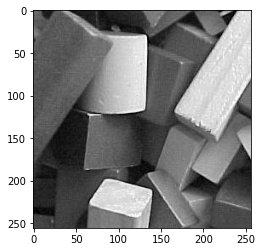

image.shape:  (256, 256)


In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

img_org = cv2.imread("blocks.jpg",0)
plt.imshow(img_org ,cmap='gray')
plt.show()
print('image.shape: ', img_org.shape)


## Step 1. Gaussian filter

original shape: (256, 256)
result shape: (256, 256)


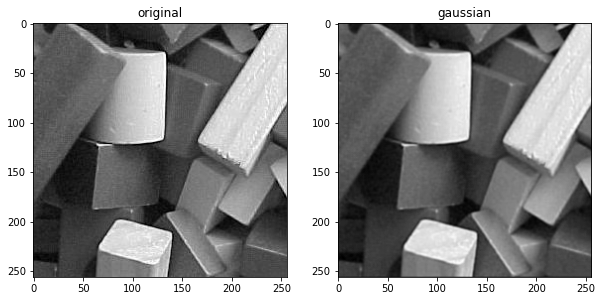

In [ ]:
def padding_img(img,k_size,style='edge'):
  # ------------ To do ------------- #
  row=np.zeros((k_size,img.shape[1]))
  img=np.row_stack((img,row))
  img=np.row_stack((row,img))
  col=np.zeros((img.shape[0],k_size))
  img=np.column_stack((img,col))
  img=np.column_stack((col,img))
  return img

def gaussian_kernel(size):
  # ------------ To do ------------- #
  sigma = 0.3*((KernelSize-1)*0.5 - 1) + 0.8
  alpha = 1 / (2 * math.pi * sigma ** 2)
  radium = KernelSize // 2
  Gaussian=[]

  total=0
  for i in range(0,KernelSize):
      Filter_list = []
      for j in range(0,KernelSize): 
          x = i - radium
          y = j - radium
          Filter_list.append(alpha * math.exp(-0.5 / (sigma ** 2) * (x ** 2 + y ** 2)))
          total += Filter_list[j]
      Gaussian+= [Filter_list]
  return np.array(Gaussian)/total

KernelSize = 3
def Gaussian_Filter(KernelSize,image):
    row,col =image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((row,col),np.uint8)
    padimg = padding_img(image,(KernelSize-1)//2,style='reflect')

    # ------------ To do ------------- #
    for i in range(resx.shape[0]):
      for j in range(resx.shape[1]):
        for u in range(0,KernelSize):
          for v in range(0,KernelSize):
            resx[i][j] += Gaussian_Kernel[u][v] * padimg[i+u][j+v]

    return resx

gaussian = Gaussian_Filter(KernelSize, img_org).astype(np.uint8)
print("original shape:", img_org.shape)
print("result shape:", gaussian.shape)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img_org ,cmap='gray')
plt.subplot(1,2,2)
plt.title("gaussian")
plt.imshow(gaussian ,cmap='gray')
plt.show()

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [ ]:
def sobel(img, filtering_type):
    h, w = img.shape

    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        
    Gx = np.zeros((h - 2, w - 2))
    Gy = np.zeros((h - 2, w - 2))

    # ------------ To do ------------- #
    for img_region, i, j in iterate_regions(img, 3):
      for x in range(3):
        for y in range(3):
          Gx[i][j] += horizontal[x][y] * img_region[x][y]
          Gy[i][j] += vertical[x][y] * img_region[x][y]

    output=np.zeros((h - 2, w - 2))
    angle=np.zeros((h - 2, w - 2))

    for i in range(h - 2):
      for j in range(w - 2):
        output[i][j] = (Gx[i][j] ** 2 + Gy[i][j] ** 2) ** 0.5
        angle[i][j] = math.atan2(Gy[i][j], Gx[i][j])

    return output, angle, Gx, Gy


def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j



gaussian shape:  (256, 256)
Horizontal Sobel filter shape:  (256, 256)
Vertical Sobel filter shape:  (256, 256)
Gradient amplitude shape:  (256, 256)


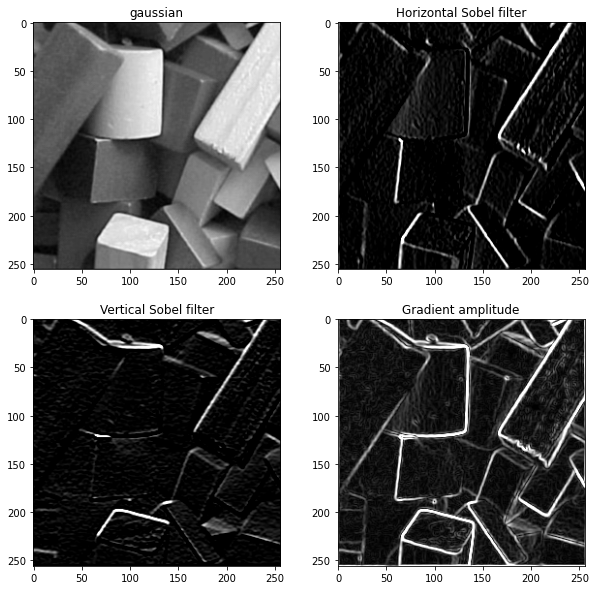

In [ ]:
# ------------ To do ------------- #
padding_gaussian = padding_img(gaussian, 1).astype(np.uint8)
gradient, angle, Gx, Gy = sobel(padding_gaussian, 'magnitude')

print("gaussian shape: ",img_org.shape)
print("Horizontal Sobel filter shape: ",Gx.shape)
print("Vertical Sobel filter shape: ",Gy.shape)
print("Gradient amplitude shape: ",Gy.shape)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("gaussian")
plt.imshow(gaussian,cmap="gray")
plt.subplot(2,2,2)
plt.title("Horizontal Sobel filter")
plt.imshow(np.clip(Gx,0,255).astype('uint8'),cmap="gray")
plt.subplot(2,2,3)
plt.title("Vertical Sobel filter")
plt.imshow(np.clip(Gy,0,255).astype('uint8'),cmap="gray")
plt.subplot(2,2,4)
plt.title("Gradient amplitude")
plt.imshow(np.clip(gradient,0,255).astype('uint8'),cmap="gray")
plt.show()


## Step 3. Non-maximum Suppression
Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [ ]:
def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
            # ------------ To do ------------- #
          if 22.5 >= angle[j][i] >= -22.5 or 180 >= angle[j][i] >= 157.5 or -157.5 >= angle[j][i] >= -180:
            if gradient_copy[j][i] != max(gradient_copy[j][i], gradient_copy[j][i-1], gradient_copy[j][i+1]):
              gradient_copy[j][i] = 0
          elif 67.5 >= angle[j][i] >= 22.5 or -112.5 >= angle[j][i] >= -157.5:
            if gradient_copy[j][i] != max(gradient_copy[j][i], gradient_copy[j+1][i-1], gradient_copy[j-1][i+1]):
              gradient_copy[j][i] = 0
          elif 112.5 >= angle[j][i] >= 67.5 or -67.5 >= angle[j][i] >= -112.5:
            if gradient_copy[j][i] != max(gradient_copy[j][i], gradient_copy[j+1][i], gradient_copy[j-1][i]):
              gradient_copy[j][i] = 0
          elif 157.5 >= angle[j][i] >= 112.5 or -22.5 >= angle[j][i] >= -67.5:
            if gradient_copy[j][i] != max(gradient_copy[j][i], gradient_copy[j-1][i-1], gradient_copy[j+1][i+1]):
              gradient_copy[j][i] = 0
    return gradient_copy

gradient, angle, Gx, Gy = sobel(padding_gaussian, 'magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient,angle)
print(After_non_maximum_supression)

[[359.23529893 384.8766036  406.00492608 ... 873.0280637  836.69468745
  784.89999363]
 [384.70768123   0.           0.         ...   0.           0.
  837.44850588]
 [398.08039389   0.           8.48528137 ...   0.           0.
  880.02045431]
 ...
 [259.3260496    0.           0.         ...   0.           0.
  286.02797066]
 [250.59928172   0.          60.41522987 ...   0.           0.
  269.29537686]
 [241.86773245 250.25187312 254.19677417 ... 281.00177935 267.30132809
  253.14817795]]


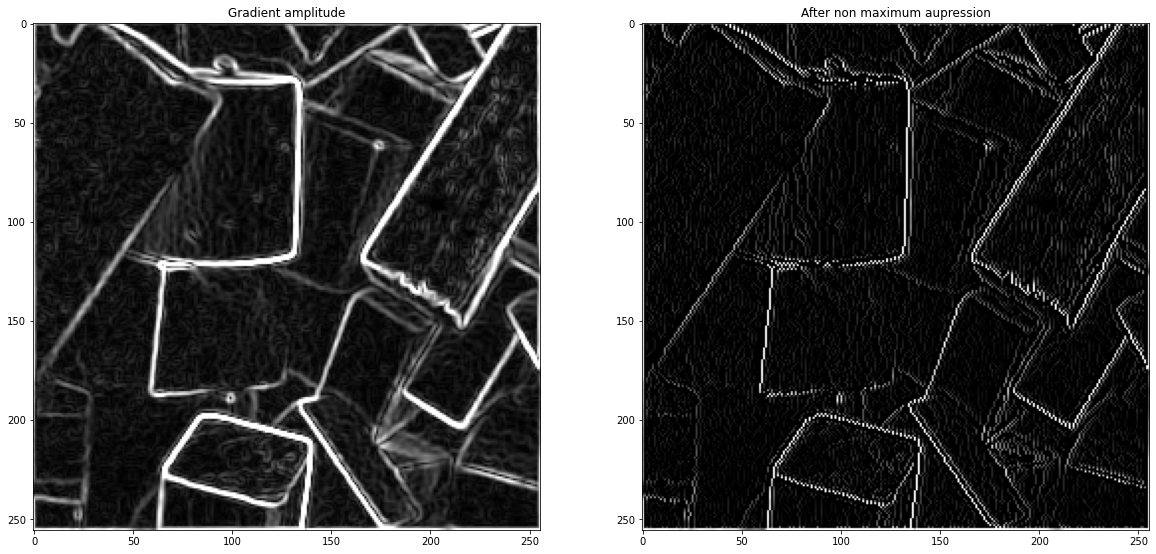

In [ ]:
# ------------ To do ------------- #
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("Gradient amplitude")
plt.imshow(np.clip(gradient,0,255),cmap="gray")
plt.subplot(1,2,2)
plt.title("After non maximum aupression")
plt.imshow(np.clip(After_non_maximum_supression,0,255).astype('uint8'),cmap="gray")
plt.show()

## Step 4. Thresholding edges

In [ ]:
def seperate(img, minimum = 60, maximum = 180):
    # ------------ To do ------------- #
    thresholding = img.copy()
    for j in range(thresholding.shape[0]):
      for i in range(thresholding.shape[1]):
        if thresholding[j][i] > maximum:
          thresholding[j][i] = 255
        elif thresholding[j][i] < minimum:
          thresholding[j][i] = 0
        else:
          thresholding[j][i] = 60
    return thresholding
After_non_maximum_supression = np.clip(After_non_maximum_supression,0,255).astype('uint8')
thresholding = seperate(After_non_maximum_supression, minimum = 15, maximum = 90)

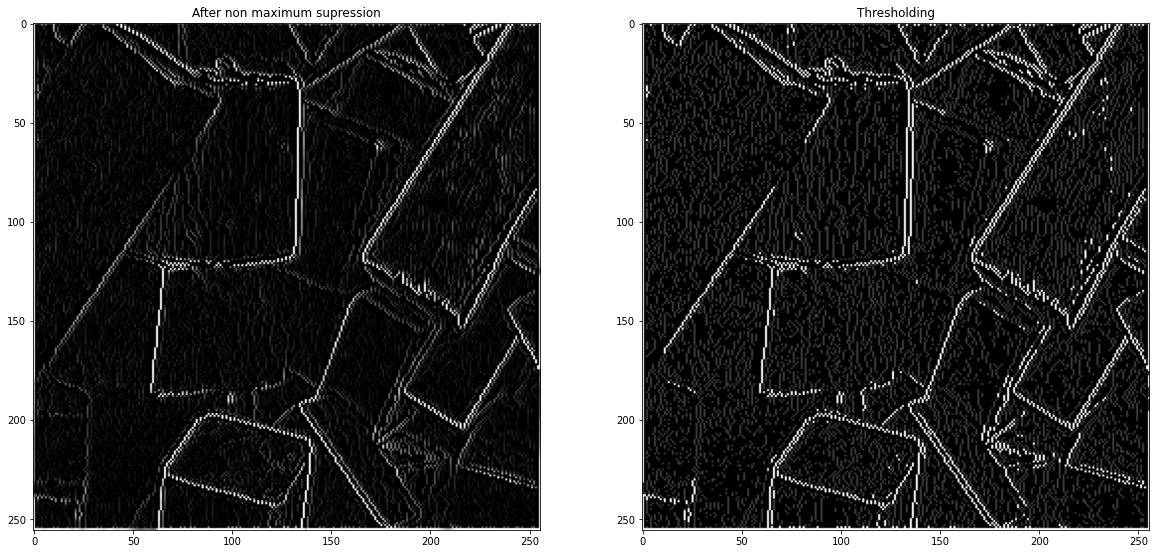

In [ ]:
# ------------ To do ------------- #
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title("After non maximum supression")
plt.imshow(After_non_maximum_supression, cmap = "gray")
plt.subplot(1,2,2)
plt.title("Thresholding")
plt.imshow(thresholding, cmap = "gray")
plt.show()

## Step 5. Hysteresis

In [ ]:
def Connect(img,weak=60):
  # ------------ To do ------------- #
  output=img.copy()
  for j in range(1,output.shape[0]-1):
    for i in range(1,output.shape[1]-1):
      if img[j][i]==weak:
        for jj in range(-1,2):
          for ii in range(-1,2):
            if img[j+jj][i+ii]==255:
              output[j][i]=255
            else:
              output[j][i]=0

  return output
weak = 60
dst_img = Connect(thresholding,weak)


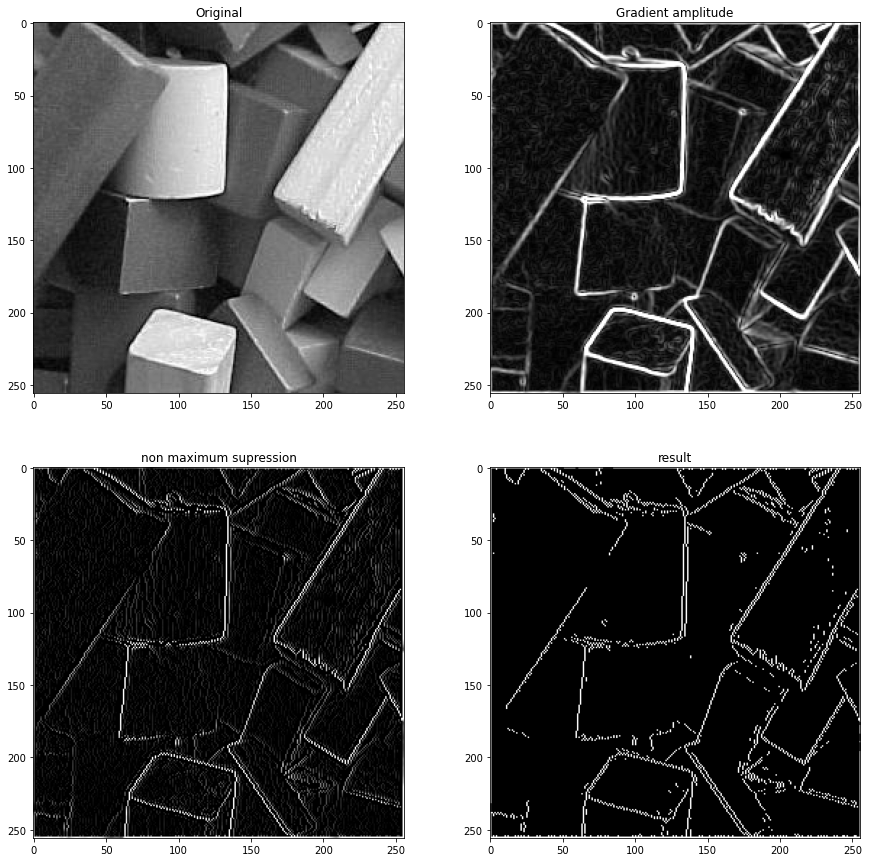

In [ ]:
# ------------ To do ------------- #
plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(np.clip(img_org, 0,255),cmap = "gray")
plt.subplot(2,2,2)
plt.title("Gradient amplitude")
plt.imshow(np.clip(gradient,0,255).astype('uint'),cmap = "gray")
plt.subplot(2,2,3)
plt.title("non maximum supression")
plt.imshow(np.clip(After_non_maximum_supression,0,255),cmap = "gray")
plt.subplot(2,2,4)
plt.title("result")
plt.imshow(np.clip(dst_img,0,255).astype('uint'),cmap = "gray")
plt.show()

# Canny Edge OpenCV 套件


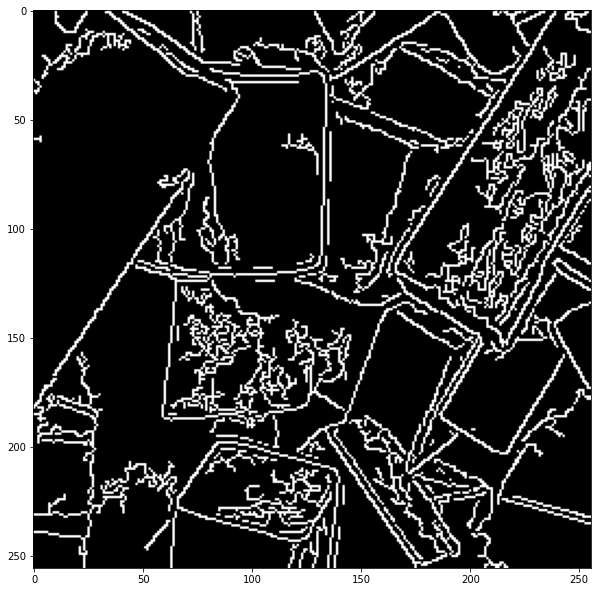

In [ ]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("blocks.jpg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

# 加分討論：為什麼和套件不一樣？

因為使用手刻和套件的threshold不同,如果沒有處理圖片整體梯度偏低的情形，有可能導致選取高的threshold 會把許多的 edge 濾掉。